## Training Model for coronal holes on SUVI
In this notebook, we provide script to train Model 18 to segment coronal holes on 195A cropped images from SDO, SOHO and SUVI.   
Training process is shown at the bottom   

install needed libraries

In [ ]:
!pip install albumentations

In [ ]:
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

import needed libraries

In [4]:
import sys, os
sys.path.append('../src/')

In [5]:
import numpy as np
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow
from keras.callbacks import ModelCheckpoint
import albumentations
from ImageDataAugmentor.image_data_augmentor import *

In [6]:
from model_scss_net import scss_net
from metrics import dice_np, iou_np, dice, iou
from utils import plot_imgs, plot_metrics


In [7]:
# define hyperparameters
IMG_SIZE = 256  # resize imgs to 256x256
BATCH_SIZE = 20 # set batch size
SEED = 42       # set seed for reproducibility
EPOCHS = 50    # Set number of epochs

# specify model filename, you should rewrite MODEL_NAME as yours preferrings
MODEL_NAME = "model_CH_SUVI"
model_filename = f"{MODEL_NAME}.h5"   

## DATA PREP

In [7]:
imgs = sorted(glob.glob("../data/train_SUVI_SDO_SOHO/imgs/*.png"))
masks = sorted(glob.glob("../data/train_SUVI_SDO_SOHO/masks/*.png"))

print(f"Imgs number = {len(imgs)}\nMasks number = {len(masks)}")

Imgs number = 7288
Masks number = 7288


In [8]:
imgs_list = []
masks_list = []
for image, mask in zip(imgs, masks):
    imgs_list.append(np.array(Image.open(image).convert("L").resize((IMG_SIZE, IMG_SIZE))))
    masks_list.append(np.array(Image.open(mask).convert("L").resize((IMG_SIZE, IMG_SIZE))))

In [9]:
# Normalization from (0; 255) to (0; 1)
x = np.asarray(imgs_list, dtype=np.float32)/255
y = np.asarray(masks_list, dtype=np.float32)/255

# Reshape to (n_imgs, height, width, channels)
x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)
y = y.reshape(y.shape[0], y.shape[1], y.shape[2], 1)

In [10]:
# create validation dataset
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=123, shuffle=True)

In [11]:
# Define augmentations for Train set
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=.5),
    albumentations.VerticalFlip(p=.5),
    albumentations.Rotate((-45, 45), p=.5, border_mode=cv2.BORDER_REPLICATE),
    albumentations.RandomGamma((100, 150), p=.5),
    albumentations.RandomBrightnessContrast((.0, .3), (.0, .5), p=.5)
])

# Generator for images
img_data_gen = ImageDataAugmentor(augment=AUGMENTATIONS, seed=SEED)
img_gen = img_data_gen.flow(x_train, batch_size=BATCH_SIZE, shuffle=True)

# Generator for annotations
mask_data_gen = ImageDataAugmentor(augment=AUGMENTATIONS, seed=SEED, label_augment_mode='mask')
mask_gen = mask_data_gen.flow(y_train, batch_size=BATCH_SIZE, shuffle=True)

# Train set with augmented data
train_gen = zip(img_gen, mask_gen)

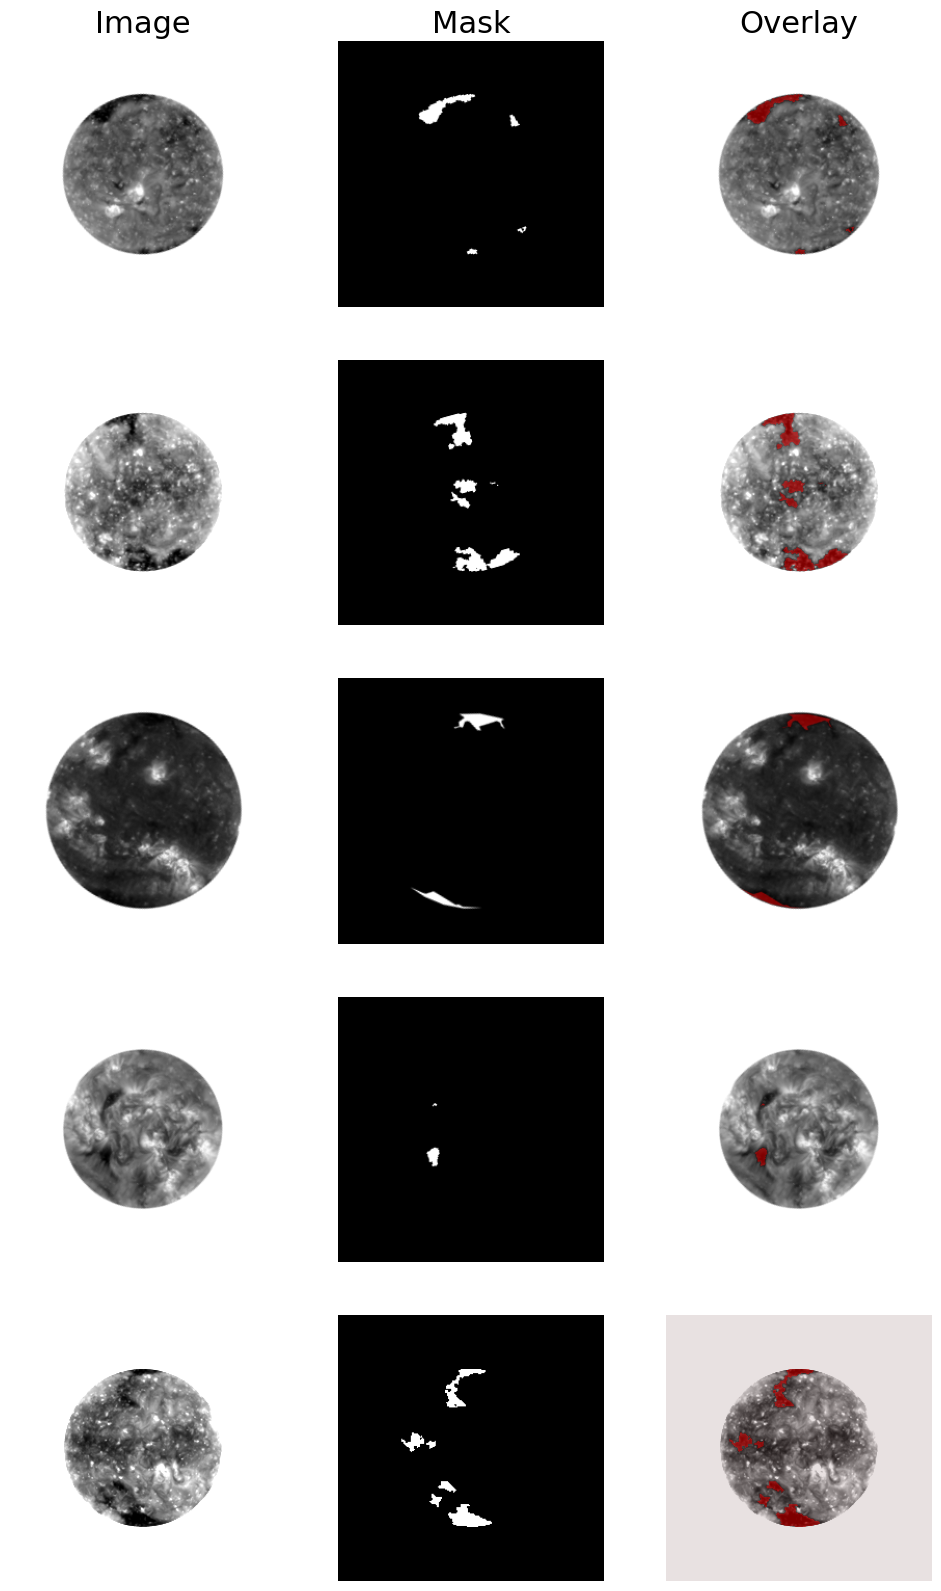

In [12]:
# Plot samples of augmented imgs
x_sample, y_sample = next(train_gen)
plot_imgs(imgs=x_sample, masks=y_sample, n_imgs=5).show()

In [13]:
# input shape should be (256, 256, 1)
input_shape = x_train[0].shape
print(f"Input shape: {input_shape}\nTrain shape: {x_train.shape}  Val shape: {x_val.shape}")

Input shape: (256, 256, 1)
Train shape: (5830, 256, 256, 1)  Val shape: (1458, 256, 256, 1)


## TRAINING MODEL

In [ ]:
# Load model architecture with optimal parameteres
model = scss_net( 
    input_shape,
    filters=32,       
    layers=4,
    batch_norm=True,
    drop_prob=0.5)

# Compile model
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",  
    metrics=[iou, dice])

# Set steps parameters acording to size of training set and size of batch
STEPS = x_train.shape[0] // BATCH_SIZE        

# Set Callback that saves only best weights
callback_checkpoint = ModelCheckpoint(
    model_filename,
    verbose=1,
    monitor="val_loss",
    save_best_only=True)
model.load_weights("model_ch_region.h5")

In [ ]:
# Train model, uncoment following lines to train
#history = model.fit(
#    x_train,
#    y_train,
#    steps_per_epoch=STEPS,
#    epochs=EPOCHS,
#    validation_data=(x_val, y_val),
#    callbacks=[callback_checkpoint],
#    verbose=2)

# # Plot training history (Metrics and Loss)
#plot_metrics(history).show()

In [ ]:
# load pretrained weights
model.load_weights(model_filename)

![Image Alt Text](../figures/train_metrics.png)